In [1]:
clear all;
clc

In [2]:
Data20F     = readtable('Data.csv');
startDate   = datenum('08-03-2017'); % This is the first month in our sample
endDate     = datenum('01-31-2023'); % This is the last month in our sample
xData       = linspace(startDate, endDate, height(Data20F(end-1382:end,1)));
xData       = datenum(xData);

In [3]:
benchmark    = table2array(Data20F(end-1382:end,2));        % Ретерни активів для бенчмарку
factors      = table2array(Data20F(end-1382:end,4:23));     % Ретерни факторів

In [4]:
function theta = calculate_theta(benchmark, factors, M, np, gam)

    T   = size(benchmark, 1);   % Total lenght
    nf  = size(factors, 2);     % Defining the number of factors
    B   = 0.8;                  % B measures how much in terms of the wealth is invested in factors

    % We are using a third dimension to save our portoflios
    theta   = NaN(nf, T-M, np);     % 3D array for factor weights

    X0  = 0 * ones(nf, 1);
    A   = ones(1, nf);
    Aeq = [];
    Beq = [];
    LB  = zeros(1, nf);
    UB  = Inf(1, nf);

    warning off

    options = optimoptions('fmincon', 'Display', 'off', 'Algorithm', 'sqp');

    for i = 1:T-M

        t0  = i;
        t   = M + i - 1;

        benchmark_est = benchmark(t0:t);
        factors_est = factors(t0:t, :);

        % Here we compute the optimal weights of factors
        min_var       = @(theta) std(benchmark_est + factors_est * theta);
        mean_var      = @(theta) - (mean(benchmark_est + factors_est * theta) ...
                                 - gam/2 * std(benchmark_est + factors_est * theta));

        %rho = 0.5;
        %sigma = cov([benchmark_est, factors_est]);
        %sigma_hat = (1-rho) * sigma + rho * mean(diag(sigma)) * eye(nf+1);
        sigma_hat = covarianceShrinkage([benchmark_est, factors_est]);

        shrink_mean_var = @(theta) - (mean(benchmark_est + factors_est * theta) ...
                                   - gam/2 * sqrt(vertcat(1, theta)' * sigma_hat * vertcat(1, theta)) );

        theta(:, i, 1)  = fmincon(mean_var, X0, A, B, Aeq, Beq, LB, UB, [], options);
        theta(:, i, 2)  = fmincon(shrink_mean_var, X0, A, B, Aeq, Beq, LB, UB, [], options);
        theta(:, i, 3)  = fmincon(min_var, X0, A, B, Aeq, Beq, LB, UB, [], options);
        theta(:, i, 4)  = CVaR(benchmark_est, factors_est, B, 0.05);
        theta(:, i, 5)  = B / nf;

    end

end

In [5]:
function rp = calculate_returns(benchmark, factors, theta, M, np)

    T  = size(benchmark, 1);  % Total lenght
    rp  = NaN(T-M, np);

    for j = 1:np
        rp(:, j) = benchmark(M+1:end,:) + sum(squeeze(theta(:,:,j))'.*factors(M+1:end,:), 2);
    end

end

In [6]:
% Now we compute the sharpe ratios and other performance
% measures of our portfolio strategies

function print_sharpe_ratios(rp)

    mv_rp   = rp(:,1);
    MDDmv   = maxdrawdown(exp(cumsum(log(1+mv_rp))));
    %STmv    = (mean(rp(:,1))/std(mv_rp(mv_rp<0))) *sqrt(252);
    %CMmn    = (mean(rp)/MDDmv) * 255;
    %CEQmv   = (mean(mv_rp) - (1/2) * var(mv_rp)) *sqrt(252);
    %SVmv    = std(mv_rp(mv_rp<0)) *sqrt(252);

    SRmv    = (mean(rp(:,1))/std(rp(:,2))) *sqrt(252);
    SRshrmv = (mean(rp(:,2))/std(rp(:,2))) *sqrt(252);
    SRmin   = (mean(rp(:,3))/std(rp(:,3))) *sqrt(252);
    SRCVaR  = (mean(rp(:,4))/std(rp(:,4))) *sqrt(252);
    SR1N    = (mean(rp(:,5))/std(rp(:,5))) *sqrt(252);

    fprintf('-----Sharpe ratios for mean-variance portfolio-----\n')
    fprintf('Sharpe ratio = %4.3f \n', SRmv)
    %fprintf('MDD = %4.3f \n', MDDmv)
    %fprintf('SV = %4.5f \n', SVmv)
    fprintf('\n -----Sharpe ratios for mean-variance portfolio with shrinkage-----\n')
    fprintf('Sharpe ratio = %4.3f \n', SRshrmv)
    fprintf('\n -----Sharpe ratios for minimum-variance portfolio-----\n')
    fprintf('Sharpe ratio = %4.3f \n', SRmin)
    fprintf('\n -----Sharpe ratios for CVaR portfolio-----\n')
    fprintf('Sharpe ratio = %4.3f \n', SRCVaR)
    fprintf('\n -----Sharpe ratios for 1/N portfolio-----\n')
    fprintf('Sharpe ratio = %4.3f \n', SR1N)

end


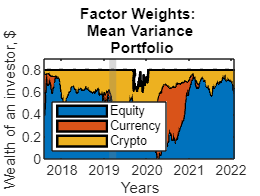


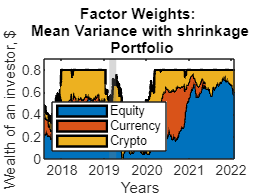

In [7]:
function plot_comulative_returns(xData, r_benchmark, rp_with_factors, M, name)

    figure;
    plot(xData(M+1:end), exp(cumsum(log(1+r_benchmark))), 'LineWidth', 1.5);
    hold on
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,1)))),'-.m', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,2)))),'-.b', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,3)))),'--r', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,4)))),'-.k', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,5)))),'-.g', 'LineWidth', 1.5)
    datetick('x', 'yyyy', 'keeplimits')
    recessionplot
    axis([xData(M+1) xData(end) -inf inf])
    xlabel('Years');
    ylabel('Wealth of an investor,  !!!EQ_1!!! ')
    title(['Factor Weights: ', port_names(p),' Portfolio'])
    legend('Equity','Currency','Crypto','Location','Southwest')

end

<center>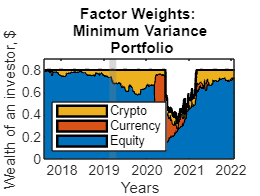</center>


<center>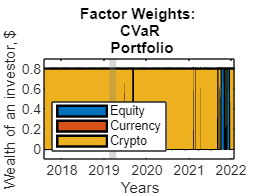</center>


<center>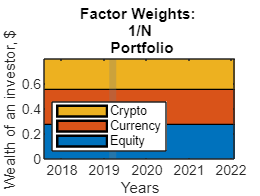</center>




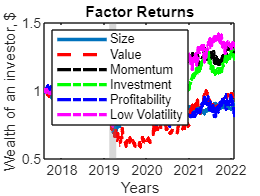

In [8]:
for p = 1:np

    port_names = [{'Mean Variance'},{'Mean Variance with shrinkage'},{'Minimum Variance'},{'CVaR'},{'1/N'}];

    figure;
    plot(xData(M+1:end), theta_all_factors(1,:,p),'LineWidth', 1.5);
    hold on
    plot(xData(M+1:end), theta_all_factors(2,:,p),'--r','LineWidth', 1.5);
    plot(xData(M+1:end), theta_all_factors(3,:,p),'-.k','LineWidth', 1.5);
    plot(xData(M+1:end), theta_all_factors(4,:,p),'-.g','LineWidth', 1.5);
    plot(xData(M+1:end), theta_all_factors(5,:,p),'-.b','LineWidth', 1.5);
    plot(xData(M+1:end), theta_all_factors(6,:,p),'-.m','LineWidth', 1.5);
    plot(xData(M+1:end), theta_all_factors(7,:,p),'-.y','LineWidth', 1.5);
    datetick('x','yyyy','keeplimits')
    recessionplot
    axis([xData(M+1) xData(end) -inf inf])
    xlabel('Years');
    ylabel('Wealth of an investor,  !!!EQ_2!!! ')
title('Factor Returns')
legend('Size','Value','Momentum','Investment','Profitability','Low Volatility','Location','Northwest')

In [9]:
% figure;
% plot(xData(M+1:end), VOL_FF6(1,:),'LineWidth',2);
% hold on
% plot(xData(M+1:end), VOL_FF6(2,:),'--r','LineWidth',2)
% plot(xData(M+1:end), VOL_FF6(3,:),'-.k','LineWidth',2)
% plot(xData(M+1:end), VOL_FF6(4,:),'-.g','LineWidth',2)
% plot(xData(M+1:end), VOL_FF6(5,:),'-.b','LineWidth',2)
% plot(xData(M+1:end), VOL_FF6(6,:),'-.m','LineWidth',2)
% datetick('x','yyyy','keeplimits')
% recessionplot
% axis([xData(M+1) xData(end) -inf inf])
% xlabel('Years');ylabel('Volatility of Factors (rolling window), %')
% title('Volatility of Factor Returns')
% legend('Size','Value','Momentum','Investment','Profitability','Low Volatility','Location','Northwest')

% figure;
% plot(xData(M+1:end), SR_FF6(1,:),'LineWidth',2);
% hold on
% plot(xData(M+1:end), SR_FF6(2,:),'--r','LineWidth',2)
% plot(xData(M+1:end), SR_FF6(3,:),'-.k','LineWidth',2)
% plot(xData(M+1:end), SR_FF6(4,:),'-.g','LineWidth',2)
% plot(xData(M+1:end), SR_FF6(5,:),'-.b','LineWidth',2)
% plot(xData(M+1:end), SR_FF6(6,:),'-.m','LineWidth',2)
% datetick('x','yyyy','keeplimits')
% recessionplot
% axis([xData(M+1) xData(end) -inf inf])
% xlabel('Years');ylabel('Sharpe Ratio of Factors (rolling window)')
% title('Sharpe Ratio of Factor Returns')
% legend('Size','Value','Momentum','Investment','Profitability','Low Volatility','Location','Northwest')